# Data analysis of skeletal muscle area and SMI for normal patients

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### Load libraries and directories

In [2]:
# from IPython import get_ipython
from IPython.display import display, HTML
#from tqdm.notebook import tqdm
import pickle
import os
import pprint
pp = pprint.PrettyPrinter(indent=1)

import pandas as pd
import numpy as np

import json

# Custom functions
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename):        
    with open(filename, 'rb') as input:
        return pickle.load(input)
    

In [3]:
# Install statsmodels if it doesn't exist
import pip
def import_or_install(package):
    try:
        return __import__(package)
    except ImportError:
        pip.main(['install', package]) 
        
packages = ['statsmodels','matplotlib','scipy','pygrowup','sklearn']

for package in packages:
    import_or_install(package)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-mc97hu6n because the default path (/home/jupyteruser/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.stats as stats
get_ipython().run_line_magic('tb', '')

No traceback available to show.


In [5]:
cwd = os.getcwd()
print(cwd)

/home/jupyteruser/smipipeline


In [6]:
data = '/home/jupyteruser/data'
pickles = '/home/jupyteruser/pickles'
models = '/home/jupyteruser/models'
output = '/home/jupyteruser/output/v5_results'

In [7]:
# Import modules and config file
configfile = os.path.join(cwd,'config/debug_ES/v5_run_prediction_CV_poorl3.json')
with open(configfile, "r") as f:
        config = json.load(f)
pp.pprint(config)

{'l3_finder': {'cache_dir': '/tf/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/tf/data',
               'model_path_dir': '/tf/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/tf/output/v5_cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/tf/models/muscle/cv_final',
                      'output_directory': '/tf/output/v5_cv_poorl3/ms'}}


In [8]:
for key in config.keys():
    for label, value in config[key].items():
        if type(value) is str:
            config[key][label] = value.replace('/tf', '/home/jupyteruser')

pp.pprint(config)

{'l3_finder': {'cache_dir': '/home/jupyteruser/_cache/',
               'cache_intermediate_results': True,
               'dicom_dir': '/home/jupyteruser/data',
               'model_path_dir': '/home/jupyteruser/models/l3/cv_final',
               'new_tim_dicom_dir_structure': True,
               'output_directory': '/home/jupyteruser/output/v5_cv_poorl3/l3',
               'overwrite': True,
               'save_plots': True,
               'show_plots': False},
 'muscle_segmentor': {'model_path_dir': '/home/jupyteruser/models/muscle/cv_final',
                      'output_directory': '/home/jupyteruser/output/v5_cv_poorl3/ms'}}


## Produce data for analysis using prediction results and preprocessing results

In [9]:
# Load the area csv
filename = 'areas-mm2_by_subject_id_manual_outliers.csv'
#filename = 'areas-mm2_by_subject_id.csv'


sma_csv = os.path.join(config["muscle_segmentor"]["output_directory"],filename)
df_sma = pd.read_csv(sma_csv, index_col=False)
print('Total number of patients for analysis before manual eliminations: ', len(df_sma))

Total number of patients for analysis before manual eliminations:  2197


In [10]:
df_man = df_sma[~df_sma['area_mm2_Elan'].isnull()]
len(df_man)

43

In [13]:
df_man.head(1)

,subject_id,area_mm2,%auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
45,Z1756629,3590.897184,7.043,7.444,3795.34838,Z1756629-SE-8-Body_Std._Axial_AIDR_-_H_Sagitta...,Z1756629-SE-2-Body_Std._Axial_AIDR_-_H__5.0


In [15]:
if 'outliers' in filename: # MOdified area sheet with manual area calculated for outlier patient
    df_sma_manuals = df_sma.loc[~df_sma['area_mm2_Elan'].isnull()]
    for i,row in df_sma_manuals.iterrows():
        df_sma.loc[df_sma['subject_id']==row['subject_id'],'area_mm2'] = row['area_mm2_Elan']
    

# Manually identified diseases cases [by Andrew]:
man_disease = ['Z832424','Z1256768']

# Manually identified poor L3s [by Elan for v5]:
man_poorl3 = ['Z627604','Z1292977','Z1150365','Z1016357','Z1335481','Z567376']

man_eliminations = man_disease + man_poorl3

df_eliminations = df_sma.loc[df_sma['subject_id'].isin(man_eliminations)]
display(df_eliminations)

,subject_id,area_mm2,%auto mask pixels,% manual mask pixels,area_mm2_Elan,sagittal_series,axial_series
635,Z1292977,6910.657248,NaN,NaN,NaN,recon from: Z1292977-SE-9-_ORAL_CONTRAST;ISOVU...,Z1292977-SE-9-_ORAL_CONTRAST;ISOVUE_300_FC12_ORG_
941,Z627604,11793.750000,NaN,NaN,NaN,Z627604-SE-9-Sagittal_Bone_Sagittal_3.000,Z627604-SE-4-Axial_Body_5.0
1007,Z1016357,4313.282220,NaN,NaN,NaN,recon from: Z1016357-SE-8-Ax-MIP_Lung_Ax-MIP_8.0,Z1016357-SE-8-Ax-MIP_Lung_Ax-MIP_8.0
1038,Z1335481,10616.937800,NaN,NaN,NaN,recon from: Z1335481-SE-10-Standard_Axial,Z1335481-SE-10-Standard_Axial
1100,Z1150365,12304.901810,NaN,NaN,NaN,recon from: Z1150365-SE-4-Axial_Body_5.0,Z1150365-SE-4-Axial_Body_5.0
2188,Z567376,7402.861004,NaN,NaN,NaN,recon from: Z567376-SE-2-Body_Std._Axial_AIDR_...,Z567376-SE-2-Body_Std._Axial_AIDR_-_H__5.0


In [16]:
df_sma= df_sma.loc[~df_sma['subject_id'].isin(man_eliminations)]
df_sma = df_sma[['subject_id','area_mm2','sagittal_series','axial_series']]
print('Final patients for analysis: ',len(df_sma))

Final patients for analysis:  2191


In [17]:
# change subject_id to id
df_sma.columns=['ID','area_mm2','sagittals','axials']
#display(df_sma.head(2))

In [18]:
# Now merge on ID
df_analysis = df_sma
#display(df_analysis.head(10))

In [19]:
# Load age information from patlist csv
# Load normal patient list
infile  = 'patlist_with_validBMI_corrected_v5.csv'
df_P = pd.read_csv(infile, index_col=False)
df_P = df_P.loc[:, ~df_P.columns.str.contains('^Unnamed')]
# Keep only columns needed
df_P = df_P[['PAT_ID','WEIGHT','HEIGHT','BMI_FOR_AGE_PERCENTILE','BMI_CALCULATED','Age',
 'Sex',
 'Race',
 'AgeGroup']]
df_P.columns = ['ID','WEIGHT','HEIGHT','BMI_AGE_P','BMI_CALC','Age','Sex','Race','AgeGroup']
#display(df_P.head(10))

In [20]:
# Get rid of patients not in df_analysis
print("Total number of normal patients identified", len(df_P))
df_P = df_P[df_P['ID'].isin(df_analysis['ID'].values)]
print("Total number of normal patients with images", len(df_P))

Total number of normal patients identified 2238
Total number of normal patients with images 2191


In [21]:
# Merge the patient fields with df_analysis
df_analysis = pd.merge(df_P,df_analysis, on="ID")

print('Length of final analysis df: ', len(df_analysis))

# Redefine AgeGroup be flooring instead of rounding.
df_analysis['AgeGroup'] = np.floor(df_analysis['Age'].values)

Length of final analysis df:  2191


In [22]:
# Manual L3 check
infile  = 'poorl3.csv'
df_poorl3 = pd.read_csv(infile, index_col=False)

l3_present = df_poorl3.loc[~df_poorl3['L3slice'].isnull(),'ID'].values.tolist()
print('Cases with manually identified L3s: ', len(l3_present))

Cases with manually identified L3s:  30


In [19]:
# This was used to filter exams for prediction in run_prediction_cv
# normal_patients_corrected = df_analysis.ID.values.tolist()
# print(len(normal_patients_corrected))
# save_object(normal_patients_corrected,os.path.join(pickles,'normal_patients_corrected.pkl'))

In [23]:
l3_present_analysis = [l3 for l3 in l3_present if l3 in df_analysis.ID.values]
print('Normal L3s that are valid: ', len(l3_present_analysis))
for l3 in l3_present_analysis:
    print(l3)

Normal L3s that are valid:  26
Z1762020
Z418856
Z357478
Z670302
Z1211258
Z717870
Z890238
Z1302641
Z627309
Z1041413
Z511402
Z1722108
Z837620
Z441830
Z5745
Z489517
Z1332420
Z1263347
Z486791
Z320930
Z678707
Z1221549
Z1274627
Z1119985
Z1000800
Z362374


In [24]:
# Find missing BMI_CALC
print('Patients missing BMI calculated:' ,len(df_analysis[df_analysis['BMI_CALC'].isnull()]))
print('Patients missing BMI age percentile:' ,len(df_analysis[df_analysis['BMI_AGE_P'].isnull()]))
print('Patients missing Height:' ,len(df_analysis[df_analysis['HEIGHT'].isnull()]))
print('Patients missing Weight' ,len(df_analysis[df_analysis['WEIGHT'].isnull()]))
print('Patients missing Age' ,len(df_analysis[df_analysis['Age'].isnull()]))
print('Patients missing Race' ,len(df_analysis[df_analysis['Race'].isnull()]))
print('Patients missing Sex' ,len(df_analysis[df_analysis['Sex'].isnull()]))

Patients missing BMI calculated: 251
Patients missing BMI age percentile: 0
Patients missing Height: 11
Patients missing Weight 27
Patients missing Age 0
Patients missing Race 0
Patients missing Sex 0


In [25]:
df_analysis = df_analysis.sort_values(by=['AgeGroup'],ascending='False')
#print(df_analysis['AgeGroup'].value_counts().sort_values())

In [26]:
list(df_analysis)

['ID',
 'WEIGHT',
 'HEIGHT',
 'BMI_AGE_P',
 'BMI_CALC',
 'Age',
 'Sex',
 'Race',
 'AgeGroup',
 'area_mm2',
 'sagittals',
 'axials']

In [27]:
# Handling an outlier that had 2 CT exams, but the exam and EHR data were mismatched. Manually correcting for it.
df_analysis.loc[df_analysis['ID']=='Z549850','Age'] = 13.99
df_analysis.loc[df_analysis['ID']=='Z549850','WEIGHT'] = np.nan
df_analysis.loc[df_analysis['ID']=='Z549850','HEIGHT'] = np.nan
df_analysis.loc[df_analysis['ID']=='Z549850','BMI_AGE_P'] = 86.5
df_analysis.loc[df_analysis['ID']=='Z549850','BMI_CALC'] = 23.66
df_analysis.loc[df_analysis['ID']=='Z549850','AgeGroup'] = 13

In [25]:
df_analysis.loc[df_analysis['ID']=='Z549850']

,ID,WEIGHT,HEIGHT,BMI_AGE_P,BMI_CALC,Age,Sex,Race,AgeGroup,area_mm2,sagittals,axials
249,Z549850,NaN,NaN,86.5,23.66,13.99,Female,Black or African American,13.0,12811.77035,Z549850-SE-5-Body_Std._Axial_AIDR_-_H_Sagittal...,Z549850-SE-2-Body_Std._Axial_AIDR_-_H__5.0


In [28]:
# Patients > 18
print('No of Patients > 18 years that are discarded' ,len(df_analysis[df_analysis['AgeGroup'] > 18]))
#print('No of Patients < 2.5 yearas' ,len(df_analysis[df_analysis['Age'] < 2.5]))

No of Patients > 18 years that are discarded 1


In [27]:
#print('No of boys' ,len(df_analysis[df_analysis['Sex'] == 'Male']))
#print('No of girls' ,len(df_analysis[df_analysis['Sex'] == 'Female']))

In [29]:
# Create sex stratified and age filtered dfs
df_analysis['area_cm2'] = df_analysis['area_mm2']/100

df_analysis['smi'] = df_analysis['area_cm2']/((df_analysis['HEIGHT']/100)**2)

df_m = df_analysis[(df_analysis['Sex']=='Male') & (df_analysis['AgeGroup'] <= 18)] #& (df_analysis['Age'] > 3)]
print('Length of male df = ',len(df_m))
df_f = df_analysis[(df_analysis['Sex']=='Female') & (df_analysis['AgeGroup'] <= 18)] # & (df_analysis['Age'] > 3)]
print('Length of female df = ',len(df_f))

Length of male df =  1056
Length of female df =  1134


In [29]:
1056/1134

0.9312169312169312

## Population statistics in comparison to CDC/WHO data

In [30]:
#Step3: Loop over each unique date in the studies dataframe df_F
def get_agewise_stats(df_in):
    uniqueages = df_in.AgeGroup.unique() 
    column_names = ['AgeGroup','Age_IQR','median_area_cm2','median_SMI','samplesize']
    df_C = pd.DataFrame(columns = column_names)
    #display(df_C)
    for age in uniqueages:
        df_l = df_in[df_in['AgeGroup']==age]
        #mean_ar = np.mean(df_l['area_cm2'])
        median_ar = np.median(df_l['area_cm2'])
        median_SMI = np.nanmedian(df_l['smi'])
        q75, q25 = np.percentile(df_l['Age'], [75 ,25])
        age_iqr = q75 - q25
        samplesize = len(df_l)
        #print([age,mean_ar,median_ar,samplesize])
        df = pd.DataFrame([[age,age_iqr,median_ar,median_SMI,samplesize]],columns=column_names)
        #display(df)
        df_C = pd.concat([df_C,df])
    return df_C

In [31]:
print('Count statistics stratified by gender and age group')
print('(M - Male) (F-Female)')    
df_f_agestats = get_agewise_stats(df_f).add_suffix('_F')
df_m_agestats = get_agewise_stats(df_m).add_suffix('_M')

display(pd.concat([df_f_agestats,df_m_agestats],axis=1))
df_f_agestats.to_csv(output+'/Female_summary.csv',index=False)
df_m_agestats.to_csv(output+'/Male_summary.csv',index=False)

Count statistics stratified by gender and age group
(M - Male) (F-Female)


,AgeGroup_F,Age_IQR_F,median_area_cm2_F,median_SMI_F,samplesize_F,AgeGroup_M,Age_IQR_M,median_area_cm2_M,median_SMI_M,samplesize_M
0,0.0,0.084796,18.652997,57.867612,6,0.0,0.206801,19.839620,57.837493,11
0,1.0,0.455484,29.410056,41.829557,3,1.0,0.000251,32.862968,47.651174,2
0,2.0,0.421892,33.671110,40.082557,19,2.0,0.299689,35.466114,42.537933,35
0,3.0,0.312682,38.022487,38.678640,22,3.0,0.525317,39.725392,40.104204,39
0,4.0,0.404026,39.722193,35.444461,17,4.0,0.408744,47.247928,39.364745,34
0,5.0,0.561457,46.824046,35.704454,27,5.0,0.517024,51.085545,39.372846,45
0,6.0,0.325437,46.835100,33.450946,39,6.0,0.445364,51.776582,36.786229,52
0,13.0,0.496507,92.737925,36.146844,102,7.0,0.553034,58.549062,36.833798,60
0,7.0,0.568820,51.911274,33.515501,38,8.0,0.423236,63.356002,36.107026,49
0,8.0,0.620310,56.929601,33.441124,48,9.0,0.500686,70.845328,36.812588,44


### Since n for age = 0 and 1 are less than 10, process only ages 2 and above.

In [32]:
print('NO of Females before filtering pats < 2yrs: ', len(df_f))
print('NO of Males before filtering pats < 2yrs: ', len(df_m))

NO of Females before filtering pats < 2yrs:  1134
NO of Males before filtering pats < 2yrs:  1056


In [33]:
df_f = df_f[df_f['Age'] >= 2]
df_m = df_m[df_m['Age'] >= 2]     

In [34]:
print('NO of Females after filtering pats < 2yrs: ', len(df_f))
print('NO of Males after filtering pats < 2yrs: ', len(df_m))

NO of Females after filtering pats < 2yrs:  1125
NO of Males after filtering pats < 2yrs:  1043


## Sample Patients for Manuscript Figures

In [73]:
def oddeven(x):
    if x & 1:
        return 'odd'
    else:
        return 'even'

In [54]:
# Sample 3 year old male with median sma
med_sma = 39.73 # From Table above
df_3_m = df_m[(df_m['AgeGroup']==3) & (df_m['area_cm2'].between(np.floor(med_sma),np.ceil(med_sma)))].sort_values(by = 'area_cm2',ascending = True)
patid = df_3_m.loc[df_3_m['area_cm2']==df_3_m['area_cm2'].median()]['ID'].iloc[0]
sma  = df_3_m.loc[df_3_m['area_cm2']==df_3_m['area_cm2'].median()]['area_cm2'].iloc[0]
smi  = df_3_m.loc[df_3_m['area_cm2']==df_3_m['area_cm2'].median()]['smi'].iloc[0]
print('Median Male patient 3 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

Median Male patient 3 year old:  Z1461248  with SMA:  39.69  and SMI:  36.7


In [61]:
# Sample 7 year old female with median sma
med_sma = 51.91 # From Table above
df_7_f = df_f[(df_f['AgeGroup']==7) & (df_f['area_cm2'].between(np.floor(med_sma),np.ceil(med_sma)))].sort_values(by = 'area_cm2',ascending = True)
if len(df_7_f) > 2:
    patid = df_7_f.loc[df_7_f['area_cm2']==df_7_f['area_cm2'].median()]['ID'].iloc[0]
    sma  = df_7_f.loc[df_7_f['area_cm2']==df_7_f['area_cm2'].median()]['area_cm2'].iloc[0]
    smi  = df_7_f.loc[df_7_f['area_cm2']==df_7_f['area_cm2'].median()]['smi'].iloc[0]
else:
    patid = df_7_f['ID'].iloc[0]
    sma  = df_7_f['area_cm2'].iloc[0]
    smi  = df_7_f['smi'].iloc[0]
print('Median FeMale patient 7 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

Median FeMale patient 7 year old:  Z1303521  with SMA:  51.12  and SMI:  31.7


In [89]:
# Sample 11 year old male with median sma
med_sma_l = 91
med_sma_h = 93 # From Table above
df_11_m = df_m[(df_m['AgeGroup']==11) & (df_m['area_cm2'].between(np.floor(med_sma_l),np.ceil(med_sma_h)))].sort_values(by = 'area_cm2',ascending = True)
#display(df_11_m)
ind = int(np.floor(np.median(list(range(0,len(df_11_m))))))
patid = df_11_m['ID'].iloc[ind]
sma  = df_11_m['area_cm2'].iloc[ind]
smi  = df_11_m['smi'].iloc[ind]
print('Median Male patient 11 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

Median Male patient 11 year old:  Z481760  with SMA:  91.04  and SMI:  45.15


In [93]:
# Sample  16 year old female with median sma
med_sma_l = 98
med_sma_h = 99 # From Table above
df_16_f = df_f[(df_f['AgeGroup']==16) & (df_f['area_cm2'].between(np.floor(med_sma_l),np.ceil(med_sma_h)))].sort_values(by = 'area_cm2',ascending = True)
#display(df_16_f)
ind = int(np.floor(np.median(list(range(0,len(df_16_f))))))
patid = df_16_f['ID'].iloc[ind]
sma  = df_16_f['area_cm2'].iloc[ind]
smi  = df_16_f['smi'].iloc[ind]
print('Median Female patient 16 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

Median Female patient 16 year old:  Z449067  with SMA:  98.43  and SMI:  36.51


In [105]:
# Sample 10 year old male at 0.05, 0.25, 0.75 and 0.95 sma
q05 = 54.627
q05_l = 54
q05_h = 57
df_tmp = df_m[(df_m['AgeGroup']==10) & (df_m['area_cm2'].between(np.floor(q05_l),np.ceil(q05_h)))].sort_values(by = 'area_cm2',ascending = True)
print(len(df_tmp))
ind = int(np.floor(np.min(list(range(0,len(df_tmp))))))
patid = df_tmp['ID'].iloc[ind]
sma  = df_tmp['area_cm2'].iloc[ind]
smi  = df_tmp['smi'].iloc[ind]
print('Q 0.05 Male patient 10 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

q25 = 62.832310335898384
df_tmp = df_m[(df_m['AgeGroup']==10) & (df_m['area_cm2'].between(np.floor(q25),np.ceil(q25)))].sort_values(by = 'area_cm2',ascending = True)
ind = int(np.floor(np.median(list(range(0,len(df_tmp))))))
patid = df_tmp['ID'].iloc[ind]
sma  = df_tmp['area_cm2'].iloc[ind]
smi  = df_tmp['smi'].iloc[ind]
print('Q 0.25 Male patient 10 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

q50 = 69.98443148678662
df_tmp = df_m[(df_m['AgeGroup']==10) & (df_m['area_cm2'].between(np.floor(q50),np.ceil(q50)))].sort_values(by = 'area_cm2',ascending = True)
ind = int(np.floor(np.median(list(range(0,len(df_tmp))))))
patid = df_tmp['ID'].iloc[ind]
sma  = df_tmp['area_cm2'].iloc[ind]
smi  = df_tmp['smi'].iloc[ind]
print('Q 0.50 Male patient 10 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

q75 = 76.36021542634919
df_tmp = df_m[(df_m['AgeGroup']==10) & (df_m['area_cm2'].between(np.floor(q75),np.ceil(q75)))].sort_values(by = 'area_cm2',ascending = True)
ind = int(np.floor(np.median(list(range(0,len(df_tmp))))))
patid = df_tmp['ID'].iloc[ind]
sma  = df_tmp['area_cm2'].iloc[ind]
smi  = df_tmp['smi'].iloc[ind]
print('Q 0.75 Male patient 10 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

q95 = 91.43285125961786
q95_l = 90
q95_h = 92
df_tmp = df_m[(df_m['AgeGroup']==10) & (df_m['area_cm2'].between(np.floor(q95_l),np.ceil(q95_h)))].sort_values(by = 'area_cm2',ascending = True)
ind = int(np.floor(np.max(list(range(0,len(df_tmp))))))
patid = df_tmp['ID'].iloc[ind]
sma  = df_tmp['area_cm2'].iloc[ind]
smi  = df_tmp['smi'].iloc[ind]
print('Q 0.95 Male patient 10 year old: ', patid, ' with SMA: ', round(sma,2), ' and SMI: ', round(smi,2))

2
Q 0.05 Male patient 10 year old:  Z509222  with SMA:  56.47  and SMI:  28.0
Q 0.25 Male patient 10 year old:  Z720289  with SMA:  62.36  and SMI:  31.81
Q 0.50 Male patient 10 year old:  Z484016  with SMA:  69.68  and SMI:  35.7
Q 0.75 Male patient 10 year old:  Z667591  with SMA:  76.47  and SMI:  41.96
Q 0.95 Male patient 10 year old:  Z549083  with SMA:  90.59  and SMI:  43.22


In [112]:
# Sample 2 patients with manual correction from df_man, minor and major variations.
df_man['relativearea_diff'] = abs(df_man['area_mm2'] - df_man['area_mm2_Elan'])/df_man['area_mm2']
df_man = df_man.sort_values(by=['relativearea_diff'],ascending=True)
#display(df_man)

# manual1 Z1762020
# manual2 Z981182
display(df_analysis[df_analysis['ID']=='Z1762020'])
display(df_analysis[df_analysis['ID']=='Z5745'])

,ID,WEIGHT,HEIGHT,BMI_AGE_P,BMI_CALC,Age,Sex,Race,AgeGroup,area_mm2,sagittals,axials,area_cm2,smi
1200,Z1762020,53.1,174.0,10.22,17.51,15.625845,Male,White,15.0,10388.33554,recon from: Z1762020-SE-8-Ax-MIP_Lung_Ax-MIP_8...,Z1762020-SE-8-Ax-MIP_Lung_Ax-MIP_8.000,103.883355,34.312114


,ID,WEIGHT,HEIGHT,BMI_AGE_P,BMI_CALC,Age,Sex,Race,AgeGroup,area_mm2,sagittals,axials,area_cm2,smi
1020,Z5745,45.5,157.48,39.43,18.34,13.813672,Male,White,13.0,8504.869932,recon from: Z5745-SE-5-Vol_Body_Vol._0.5,Z5745-SE-5-Vol_Body_Vol._0.5,85.048699,34.293899


### Calculate Z-scores for bmi, height and weight w.r.t to age from WHO/CDC data

In [35]:
1125+1043

2168

In [36]:
#pip install pygrowup
from pygrowup import Calculator
from pygrowup import helpers

calculator = Calculator(include_cdc=True)

def percentile_for_zscore(zscore):
    return stats.norm.cdf(zscore)

def zscore_for_percentile(p):
    return stats.norm.ppf(p)

def add_Z_scores(row):
    try:
        global calculator
        valid_age = row['Age']*12
        valid_gender = helpers.get_good_sex(row['Sex'])
        if (np.isnan(row['HEIGHT'])):
            row['height_age_Zscore'] = row["HEIGHT"]
        else:
            row['height_age_Zscore'] = float(calculator.lhfa(row['HEIGHT'],valid_age,valid_gender))
        
        if (np.isnan(row['WEIGHT'])):
            row['weight_age_Zscore'] = row["WEIGHT"]
        else:
            row['weight_age_Zscore'] = float(calculator.wfa(row['WEIGHT'],valid_age,valid_gender))
            
        if (np.isnan(row['BMI_AGE_P'])):
            row['bmi_age_Zscore'] = row['BMI_AGE_P']
        else:
            row['bmi_age_Zscore'] = zscore_for_percentile(row['BMI_AGE_P']/100)
    except:
        print(row)
        raise
    return row


def add_Zpercentile_scores(row):
    try:
        if (np.isnan(row['weight_age_Zscore'])):
            row['weight_age_Zpercentile'] = row["weight_age_Zscore"]
        else:
            row['weight_age_Zpercentile'] = 100*percentile_for_zscore(row["weight_age_Zscore"])
        
        if (np.isnan(row['height_age_Zscore'])):
            row['height_age_Zpercentile'] = row["height_age_Zscore"]
        else:
            row['height_age_Zpercentile'] = 100*percentile_for_zscore(row["height_age_Zscore"])
    except:
        print(row)
        raise
    return row

In [37]:
df_m = df_m.apply(add_Z_scores,axis=1)
df_m = df_m.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_m = df_m.apply(add_Zpercentile_scores,axis=1)

In [38]:
df_f = df_f.apply(add_Z_scores,axis=1)
df_f = df_f.rename({'BMI_AGE_P':'bmi_age_Zpercentile'},axis=1)
#df_m.weight_age_Zscore = df_m.weight_age_Zscore.astype(float)
#df_m.height_age_Zscore = df_m.height_age_Zscore.astype(float)
#df_m.bmi_age_Zscore = df_m.bmi_age_Zscore.astype(float)
df_f = df_f.apply(add_Zpercentile_scores,axis=1)

In [39]:
# Compute descriptive statistics on the dataframe
def calculate_stats(df):
    num_list = ['BMI_CALC','WEIGHT','HEIGHT','Age','area_cm2','smi','height_age_Zscore','height_age_Zpercentile',
                'weight_age_Zscore','weight_age_Zpercentile','bmi_age_Zscore','bmi_age_Zpercentile']
    df_num = df[num_list]
    df_d = df_num.describe()
    df_whites = df.loc[df['Race']=='White',num_list].describe()
    df_blacks = df.loc[df['Race']=='Black or African American',num_list].describe()
    df_others = df.loc[(df['Race']!='Black or African American') & (df['Race']!='White'),num_list].describe()
    
    df_whites = df_whites.add_suffix('_W')
    df_blacks = df_blacks.add_suffix('_B')
    df_others = df_others.add_suffix('_O')
    return pd.concat([df_d, df_whites,df_blacks,df_others], axis=1)

In [40]:
df_m_stats= calculate_stats(df_m).T.round(decimals=2)
df_f_stats = calculate_stats(df_f).T.round(decimals=2)

In [41]:
print("Population Statistics for Male")
display(df_m_stats.head(12))
df_f_stats.to_csv(output+'/Female_summary_statistics.csv',index=True)
df_m_stats.to_csv(output+'/Male_summary_statistics.csv',index=True)

Population Statistics for Male


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,903.0,19.02,3.20,13.59,16.44,18.49,21.19,31.02
WEIGHT,1027.0,45.45,20.57,10.80,27.60,43.70,62.15,99.00
HEIGHT,1039.0,148.47,26.95,82.00,128.10,152.40,171.52,205.74
Age,1043.0,11.52,4.45,2.00,7.89,12.16,15.27,18.90
area_cm2,1043.0,94.43,40.23,22.57,60.87,87.44,126.60,208.75
smi,1039.0,40.79,6.83,23.77,35.86,40.11,45.49,66.70
height_age_Zscore,1039.0,0.29,1.15,-3.55,-0.46,0.30,1.00,4.26
height_age_Zpercentile,1039.0,57.72,30.07,0.02,32.10,61.79,84.13,100.00
weight_age_Zscore,1027.0,0.36,0.90,-4.21,-0.24,0.41,1.02,2.76
weight_age_Zpercentile,1027.0,61.31,26.80,0.00,40.71,65.91,84.61,99.71


In [42]:
print("Population Statistics for Female")
display(df_f_stats.head(12))

Population Statistics for Female


,count,mean,std,min,25%,50%,75%,max
BMI_CALC,1016.0,20.52,3.70,11.64,17.56,20.40,23.19,29.97
WEIGHT,1113.0,48.96,17.14,8.60,35.83,52.00,62.10,89.00
HEIGHT,1118.0,150.60,20.21,74.00,141.50,157.48,164.50,191.00
Age,1125.0,13.00,4.07,2.05,10.45,14.13,16.17,18.94
area_cm2,1125.0,84.53,24.44,25.69,67.87,88.03,102.62,147.07
smi,1118.0,36.58,5.36,21.97,32.90,36.00,39.96,77.90
height_age_Zscore,1118.0,0.14,1.11,-7.65,-0.55,0.14,0.83,5.00
height_age_Zpercentile,1118.0,54.14,29.64,0.00,29.20,55.57,79.67,100.00
weight_age_Zscore,1113.0,0.42,0.84,-3.91,-0.10,0.54,1.04,2.37
weight_age_Zpercentile,1113.0,63.91,25.25,0.00,46.02,70.54,85.08,99.11


## Correlation metrics

In [43]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 9)
    return pvalues

# Function to calculate Pearson's correlation coefficient (r) with confidence intervals in python!
# https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
from scipy import stats
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def calculate_pearsonr_with_ci_pval(df):
    # https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pearson_r = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            cor, p, lo, hi = pearsonr_ci(df[r],df[c])
            pearson_r[r][c] = str(round(cor,2)) + " (" + str(round(lo,2)) + " - " + str(round(hi,2)) + "), p = " + '{:0.2e}'.format(p)
    return pearson_r

In [44]:
print('Pearson with CI and P-values')
df_m_cor_p = calculate_pearsonr_with_ci_pval(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']])
display(df_m_cor_p)
df_m_cor_p.to_csv(output+'/Male_pearsonr_with_ci.csv',index=True)

Pearson with CI and P-values


<ipython-input-43-3a95e323aef5>:36: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,"1.0 (1.0 - 1.0), p = 0.00e+00","0.94 (0.93 - 0.94), p = 0.00e+00","0.91 (0.9 - 0.92), p = 0.00e+00","0.86 (0.84 - 0.87), p = 9.51e-256","0.19 (0.12 - 0.25), p = 2.66e-08","0.94 (0.93 - 0.95), p = 0.00e+00","0.42 (0.36 - 0.47), p = 8.98e-39"
HEIGHT,"0.94 (0.93 - 0.94), p = 0.00e+00","1.0 (1.0 - 1.0), p = 0.00e+00","0.95 (0.95 - 0.96), p = 0.00e+00","0.68 (0.65 - 0.72), p = 4.75e-123","-0.01 (-0.08 - 0.05), p = 7.09e-01","0.9 (0.89 - 0.91), p = 0.00e+00","0.25 (0.18 - 0.31), p = 1.22e-13"
Age,"0.91 (0.9 - 0.92), p = 0.00e+00","0.95 (0.95 - 0.96), p = 0.00e+00","1.0 (1.0 - 1.0), p = 0.00e+00","0.7 (0.66 - 0.73), p = 5.90e-131","-0.06 (-0.12 - 0.01), p = 9.47e-02","0.89 (0.88 - 0.91), p = 1.10e-309","0.32 (0.25 - 0.37), p = 6.11e-22"
BMI_CALC,"0.86 (0.84 - 0.87), p = 9.51e-256","0.68 (0.65 - 0.72), p = 4.75e-123","0.7 (0.66 - 0.73), p = 5.90e-131","1.0 (1.0 - 1.0), p = 0.00e+00","0.54 (0.49 - 0.59), p = 1.60e-68","0.79 (0.77 - 0.82), p = 5.24e-193","0.57 (0.52 - 0.61), p = 4.11e-76"
bmi_age_Zpercentile,"0.19 (0.12 - 0.25), p = 2.66e-08","-0.01 (-0.08 - 0.05), p = 7.09e-01","-0.06 (-0.12 - 0.01), p = 9.47e-02","0.54 (0.49 - 0.59), p = 1.60e-68","1.0 (1.0 - 1.0), p = 0.00e+00","0.13 (0.06 - 0.19), p = 1.80e-04","0.35 (0.29 - 0.4), p = 1.69e-26"
area_cm2,"0.94 (0.93 - 0.95), p = 0.00e+00","0.9 (0.89 - 0.91), p = 0.00e+00","0.89 (0.88 - 0.91), p = 1.10e-309","0.79 (0.77 - 0.82), p = 5.24e-193","0.13 (0.06 - 0.19), p = 1.80e-04","1.0 (1.0 - 1.0), p = 0.00e+00","0.62 (0.57 - 0.66), p = 3.19e-94"
smi,"0.42 (0.36 - 0.47), p = 8.98e-39","0.25 (0.18 - 0.31), p = 1.22e-13","0.32 (0.25 - 0.37), p = 6.11e-22","0.57 (0.52 - 0.61), p = 4.11e-76","0.35 (0.29 - 0.4), p = 1.69e-26","0.62 (0.57 - 0.66), p = 3.19e-94","1.0 (1.0 - 1.0), p = 0.00e+00"


In [45]:
print('Correlation Map Male')
display(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_m_cor = df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_m_cor.to_csv(output+'/Male_correlation_statistics.csv',index=True)

Correlation Map Male


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.937,0.912,0.856,0.163,0.939,0.422
HEIGHT,0.937,1.000,0.952,0.686,-0.014,0.901,0.246
Age,0.912,0.952,1.000,0.700,-0.054,0.891,0.319
BMI_CALC,0.856,0.686,0.700,1.000,0.544,0.793,0.559
bmi_age_Zpercentile,0.163,-0.014,-0.054,0.544,1.000,0.107,0.293
area_cm2,0.939,0.901,0.891,0.793,0.107,1.000,0.621
smi,0.422,0.246,0.319,0.559,0.293,0.621,1.000


In [46]:
print('P-values for Correlation map - male, P < 0.05 are statistically significant')
df_m_cor_p = calculate_pvalues(df_m[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_m_cor_p)
df_m_cor_p.to_csv(output+'/Male_correlation_pvalues.csv',index=True)

P-values for Correlation map - male, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
Age,0.0,0.0,0.0,0.0,0.0,0.0
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
print('Pearson with CI and P-values')
df_f_cor_p = calculate_pearsonr_with_ci_pval(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']])
display(df_f_cor_p)
df_f_cor_p.to_csv(output+'/Female_pearsonr_with_ci.csv',index=True)

Pearson with CI and P-values


<ipython-input-43-3a95e323aef5>:36: RuntimeWarning: divide by zero encountered in arctanh
  r_z = np.arctanh(r)


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,"1.0 (1.0 - 1.0), p = 0.00e+00","0.89 (0.88 - 0.91), p = 0.00e+00","0.86 (0.85 - 0.88), p = 1.21e-299","0.87 (0.86 - 0.89), p = 3.74e-317","0.42 (0.37 - 0.47), p = 4.32e-44","0.9 (0.88 - 0.91), p = 0.00e+00","0.24 (0.18 - 0.3), p = 9.20e-15"
HEIGHT,"0.89 (0.88 - 0.91), p = 0.00e+00","1.0 (1.0 - 1.0), p = 0.00e+00","0.89 (0.88 - 0.9), p = 0.00e+00","0.62 (0.58 - 0.66), p = 1.99e-107","0.13 (0.06 - 0.19), p = 6.20e-05","0.86 (0.84 - 0.87), p = 4.75e-291","0.0 (-0.06 - 0.07), p = 9.15e-01"
Age,"0.86 (0.85 - 0.88), p = 1.21e-299","0.89 (0.88 - 0.9), p = 0.00e+00","1.0 (1.0 - 1.0), p = 0.00e+00","0.69 (0.65 - 0.72), p = 1.08e-140","0.1 (0.04 - 0.16), p = 1.64e-03","0.82 (0.8 - 0.84), p = 3.78e-248","0.13 (0.07 - 0.19), p = 2.39e-05"
BMI_CALC,"0.87 (0.86 - 0.89), p = 3.74e-317","0.62 (0.58 - 0.66), p = 1.99e-107","0.69 (0.65 - 0.72), p = 1.08e-140","1.0 (1.0 - 1.0), p = 0.00e+00","0.69 (0.66 - 0.73), p = 2.11e-145","0.75 (0.72 - 0.78), p = 3.46e-184","0.43 (0.38 - 0.48), p = 4.67e-46"
bmi_age_Zpercentile,"0.42 (0.37 - 0.47), p = 4.32e-44","0.13 (0.06 - 0.19), p = 6.20e-05","0.1 (0.04 - 0.16), p = 1.64e-03","0.69 (0.66 - 0.73), p = 2.11e-145","1.0 (1.0 - 1.0), p = 0.00e+00","0.31 (0.26 - 0.37), p = 1.76e-24","0.4 (0.34 - 0.45), p = 7.37e-39"
area_cm2,"0.9 (0.88 - 0.91), p = 0.00e+00","0.86 (0.84 - 0.87), p = 4.75e-291","0.82 (0.8 - 0.84), p = 3.78e-248","0.75 (0.72 - 0.78), p = 3.46e-184","0.31 (0.26 - 0.37), p = 1.76e-24","1.0 (1.0 - 1.0), p = 0.00e+00","0.5 (0.45 - 0.54), p = 4.76e-64"
smi,"0.24 (0.18 - 0.3), p = 9.20e-15","0.0 (-0.06 - 0.07), p = 9.15e-01","0.13 (0.07 - 0.19), p = 2.39e-05","0.43 (0.38 - 0.48), p = 4.67e-46","0.4 (0.34 - 0.45), p = 7.37e-39","0.5 (0.45 - 0.54), p = 4.76e-64","1.0 (1.0 - 1.0), p = 0.00e+00"


In [48]:
print('Correlation Map Female')
display(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3))
df_f_cor = df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','bmi_age_Zpercentile','area_cm2','smi']].corr().round(3)
df_f_cor.to_csv(output+'/Female_correlation_statistics.csv',index=True)

Correlation Map Female


,WEIGHT,HEIGHT,Age,BMI_CALC,bmi_age_Zpercentile,area_cm2,smi
WEIGHT,1.000,0.895,0.866,0.875,0.395,0.896,0.251
HEIGHT,0.895,1.000,0.891,0.620,0.111,0.857,0.011
Age,0.866,0.891,1.000,0.686,0.086,0.824,0.143
BMI_CALC,0.875,0.620,0.686,1.000,0.697,0.752,0.427
bmi_age_Zpercentile,0.395,0.111,0.086,0.697,1.000,0.292,0.372
area_cm2,0.896,0.857,0.824,0.752,0.292,1.000,0.506
smi,0.251,0.011,0.143,0.427,0.372,0.506,1.000


In [49]:
print('P-values for Correlation map - female, P < 0.05 are statistically significant')
df_f_cor_p = calculate_pvalues(df_f[['WEIGHT','HEIGHT','Age','BMI_CALC','area_cm2','smi']])
display(df_f_cor_p)
df_f_cor_p.to_csv(output+'/Female_correlation_pvalues.csv',index=True)

P-values for Correlation map - female, P < 0.05 are statistically significant


,WEIGHT,HEIGHT,Age,BMI_CALC,area_cm2,smi
WEIGHT,0.0,0.0,0.0,0.0,0.0,0.0
HEIGHT,0.0,0.0,0.0,0.0,0.0,0.914799
Age,0.0,0.0,0.0,0.0,0.0,0.000024
BMI_CALC,0.0,0.0,0.0,0.0,0.0,0.0
area_cm2,0.0,0.0,0.0,0.0,0.0,0.0
smi,0.0,0.914799,0.000024,0.0,0.0,0.0


## Quantile Regression with Splines

In [50]:
# Get Restricted Cubic splines by transforming independent variable (age)
from statsmodels.regression.quantile_regression import QuantReg as QR
# Reference: 
from patsy import dmatrix
from patsy import cr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt

In [51]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
#Must be activated
pandas2ri.activate()
utils = importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages('quantreg')
qr_package=importr('quantreg')

In [52]:
def get_knots(x,nknots):
    # Knot locations are set based on this article
    #https://support.sas.com/resources/papers/proceedings16/5621-2016.pdf
    if nknots == 3:
        return [x.quantile(0.1),x.quantile(0.5),x.quantile(0.9)]
    elif nknots == 4:
        return [x.quantile(0.05),x.quantile(0.35),x.quantile(0.65),x.quantile(0.95)]
    elif nknots == 5:
        return [x.quantile(0.05),x.quantile(0.275),x.quantile(0.5),x.quantile(0.725),x.quantile(0.95)]

In [53]:
def fit_bs_models(model,qlist):
    res = [model.fit(q=q) for q in qlist] 
    return res

def get_transformed_x(x,knots,degrees):
    transformed_x = dmatrix("bs(train, knots=" + knots +", degree= "+ str(degrees) 
                    +",include_intercept=False)", {"train": x},return_type='dataframe')
    return transformed_x

def find_points_above(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data > y_m
    outlier_count = sum(points)
    return outlier_count, points

def find_points_below(model,x_data,y_data):
    y_m = model.predict(x_data)
    points = y_data < y_m
    outlier_count = sum(points)
    return outlier_count, points

In [54]:
units_dict = {'WEIGHT':'Weight (Kg)','Age':'Age (Years)', 'HEIGHT': 'Height (cm)', 'area_cm2': 'SMA (cm^2)', 'smi': 'SMI (cm^2/m^2)',
             'BMI_CALC': ' BMI', 'bmi_age_Zpercentile': 'BMI for Age (Z-percentile)'}

# Gets design matrix command for restricted cubic splines (RCS)
def get_dm_command_RCS(DF,knots):
    lb = knots[0]
    ub = knots[-1]
    internal = knots[1:-1] # Internal knots
    
    command_head = "cr(train,df = " +  str(DF) + ", knots="

    command_mid  = ""
    internal_str=  list(map(str,internal))
    #print(internal_str)
    if len(internal_str)==1:
        command_mid = internal_str[0]
    else:
        command_mid = "(" + internal_str[0] 
        for i in internal_str[1:]:
            command_mid = command_mid + ',' + i    
        command_mid = command_mid + ')'

    command_tail = ", lower_bound=" + str(lb) +", upper_bound=" + str(ub) + ") -1"
    command = command_head + command_mid + command_tail
    return command

def get_aic_rpy2(dm,df,response_var,q=0.5):
    # Change colnames
    colnames = []
    for i in range(len(list(dm))):
        ind = i+1
        colnames.append('x' + str(ind))
        
    #print(colnames)    
    dm.columns = colnames

    # Add Jitter, Required for R QR
    df_R = robjects.r['as.matrix'](dm)
    df_R  = robjects.r['jitter'](df_R)
    dm_jitter = dm.copy()

    # Add response var to df for Quantile Reg in Rpy2
    dm_jitter.iloc[:,:] = df_R
    dm_jitter[response_var] = df[response_var].values


    # QR Command
    qr_head = response_var + ' ~ '
    qr_tail = colnames[0]
    for i in colnames[1:]:
        qr_tail = qr_tail + '+' + i
    qr_command = qr_head + qr_tail
    #print('qr_command:', qr_command)

    # Perform QR and find AIC
    qr_mod = qr_package.rq(qr_command,data=dm_jitter, tau=q)
    AIC = qr_package.AIC_rq(qr_mod)[0]

    return AIC

def spline_model_optimizer_cr(df,response_var,predictor_var='Age',nknots=[3,4,5]):
    # Storage parameters
    model_dict = {}
    
    # Akaike defined by Elan
    akaike_dict = {}
    mean_akaike = {}
    akaike_dict_25 = {}
    akaike_dict_75 = {}
    
    # AIC from R for quantreg models
    aic_dict = {}
    mean_aic = {}
    aic_dict_25 = {}
    aic_dict_75 = {}

    # Maximum Likelihood calculated by Elan
    L_dict = {}
    L_dict_25 = {}
    L_dict_75 = {}
    
    knots_dict = {} 
    model_keys = []
    
    # Knot constraints
    min_knot = 3
    max_knot = 15 + 1 # [+1 for python]
    min_knot_diff = 3
    
    # Iterate over all knots
    for nknot in nknots :
        knots = get_knots(np.floor(df[predictor_var]),nknot)

        # Book-keeping
        mkey = 'nknots_'+ str(nknot)
        model_keys.append(mkey)
        knots_dict[mkey] = knots

        #print('knots: ', knots)
        command = get_dm_command_RCS(nknot,knots)
       # print(command)
        transformed_age = dmatrix(command, {"train": df[predictor_var].values}, return_type='dataframe')
       
        # Fit qr model
        qr_model = QR(df[response_var].values,transformed_age.values)
        model_dict[mkey] = qr_model
        
        # Calculate AIC from R qr function
        aic_dict[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.5)
        aic_dict_25[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.25)
        aic_dict_75[mkey] = get_aic_rpy2(transformed_age,df,response_var,q=0.75)
        
        # Calculate mean aic
        mean_aic[mkey] = (aic_dict[mkey] + aic_dict_25[mkey] + aic_dict_75[mkey])/3
            
    # Find best model
    best_model_raic= min(mean_aic, key=mean_aic.get)
    return model_dict[best_model_raic],knots_dict[best_model_raic]

def plot_bs_qr_cr(dfs,mlist,knots,sexes=['Male','Female'],predictor='Age',response='area_cm2',xstart=0, ystart = 0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    #age_range = dfs[0][predictor].values.max() - dfs[0][predictor].values.min()
    #x_df = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),int(age_range*2))
    x_df = np.arange(2.0, 19.5, 0.5)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    results_df = pd.DataFrame(columns = ['Age','0.05','0.25','0.50','0.75','0.95','0.05','0.25','0.50','0.75','0.95'])
    results_df['Age'] =  x_df
        #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe') 
        transformed_x_df = dmatrix(command, {"train": x_df}, return_type='dataframe') 
        
        ax = plt.subplot(1,2,n+1)
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            y_df = models[i].predict(transformed_x_df)
            if n == 0:
                results_df.iloc[:,i+1] = y_df
            else:
                results_df.iloc[:,i+6] = y_df
                
            ax.plot(x, y, linestyle='dotted',label='q =' + str(round(models[i].q,2)),linewidth=3)
          
        # Plot outliers in red
        x_data = df[predictor].values
        tr_x_data = dmatrix(command, {"train": x_data}, return_type='dataframe')
        y_data = df[response].values
        _,outliers_above = find_points_above(models[-1],tr_x_data,y_data)
        _,outliers_below = find_points_below(models[0],tr_x_data,y_data)
       # print('Number of outliers > 0.90: ', sum(outliers_above))
       # print('Number of outliers < 0.10: ', sum(outliers_below))
        outliers = outliers_above | outliers_below
        
        print('Total outliers: ', sum(outliers), 'Total points: ', len(outliers))
        
        normals = ~ outliers
        ax.scatter(x_data[normals], y_data[normals],facecolor=None, edgecolor = 'k', alpha=.05)
        ax.scatter(x_data[outliers], y_data[outliers],facecolor=None, edgecolor = 'r', alpha=.25)
        
       #ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
       # print(np.ceil(max(df[predictor].values)))
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))),auto=True)
        
        print('xstart: ',xstart)
        print('ystart: ',ystart)
        ax.set_ylim(ystart, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        if predictor == "BMI_CALC":
            ax.set_xlim(xstart, np.ceil(max(df[predictor].values)),auto=True)
            xtick_r = 2
            ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        
        ax.set_yticks(np.arange(ystart,ymax,20))
        ax.set_xlabel(units_dict[predictor], fontsize=18)
        ax.set_ylabel(units_dict[response], fontsize=18)
        ax.set_title(sexes[n], fontsize=18)
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)
    
    
    return results_df

def plot_bs_qr_wcdc_cr(dfs,mlist,knots,cdc_df,sexes=['Male','Female'],predictor='Age',response='area_cm2',xstart=0, ystart=0):
    x = np.linspace(dfs[0][predictor].values.min(),dfs[0][predictor].values.max(),70)
    ymax = max(max(dfs[0][response]),max(dfs[0][response]))
    plt.figure(figsize = (14,7),linewidth=2)
    
    colors = ['r','g','c','m','b']
    #fig, ax = plt.subplots(figsize=(8, 6))
    for n in range(len(mlist)):
        df = dfs[n]
        models = mlist[n]
        
        cdc_df_sex = cdc_df[cdc_df['Sex']==n+1]
        
        command = get_dm_command_RCS(len(knots[n]),knots[n])
        # print(command)
        transformed_x = dmatrix(command, {"train": x}, return_type='dataframe')
        ax = plt.subplot(1,2,n+1)
        
        for i in range(len(models)):
            y = models[i].predict(transformed_x)
            ax.plot(x, y, linestyle='dotted',color=colors[i],label='q =' + str(round(models[i].q,2)),linewidth=3)
            ax.plot(cdc_df_sex.iloc[:,1],cdc_df_sex.iloc[:,i+2],color=colors[i],label='cdc, q =' + str(round(models[i].q,2)),linewidth=2)

        ax.scatter(df[predictor], df[response],facecolor=None, edgecolor = 'k', alpha=.1)
        ax.set_xlim((xstart, np.ceil(max(df[predictor].values))))
        print('xstart: ',xstart)
        print('ystart: ',ystart)
        ax.set_ylim(ystart, ymax,auto=True)
        legend = ax.legend()
        if np.ceil(max(df[predictor].values)) > 20:
            xtick_r = 20
        else:
            xtick_r = 1
        ax.set_xticks(np.arange(xstart,np.ceil(max(df[predictor].values)),xtick_r))
        ax.set_yticks(np.arange(ystart,ymax,10))
        ax.set_xlabel(units_dict[predictor], fontsize=18)
        ax.set_ylabel(units_dict[response], fontsize=18)
        ax.set_title(sexes[n], fontsize=18)
    title = response +'_vs_'+predictor+'.png'
    plt.tight_layout()
    plt.savefig(os.path.join(output,title), dpi = 300)  

In [55]:
# Import cdc data
# 2 to 20years
#infile  = '/tf/smipipeline/growth_curves/data/csv/wtage220.csv'
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

# infants to 3 years
#infile2  = '/tf/smipipeline/growth_curves/data/csv/wtageinf.csv'
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/wtageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='WEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m= spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Population comparison to cdc data on WEIGHT using quantile regression
xstart:  0
ystart:  0
xstart:  0
ystart:  0


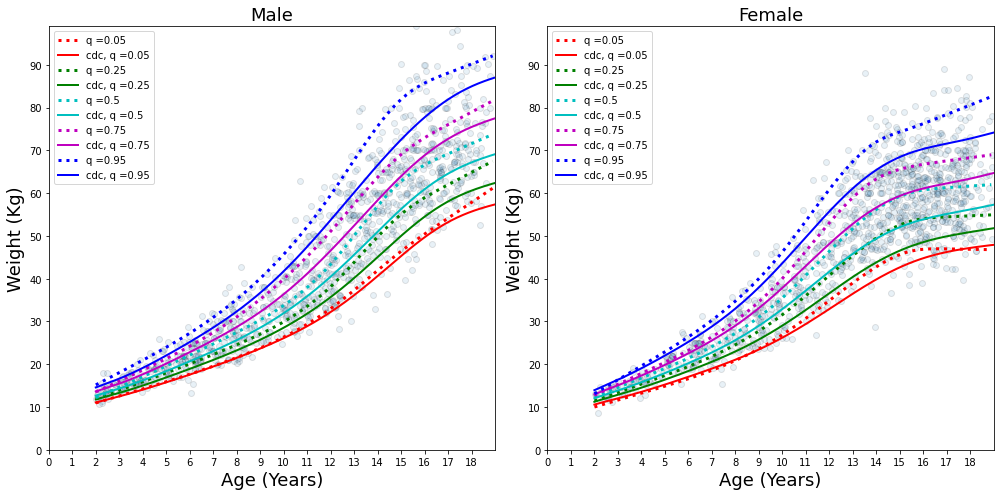

In [56]:
# Plot the results
print('Population comparison to cdc data on ' + response + ' using quantile regression')

cdc_df = cdc_df[cdc_df['Age']>=2]

plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           cdc_df = cdc_df,
           response=response)

In [57]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/statage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]
# infants to 3 years
infile2  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/lenageinf.csv'
df_cdc_wt2= pd.read_csv(infile2, index_col=False)
df_cdc_wt2['Age'] = df_cdc_wt2['Agemos']/12
df_cdc_wt2 = df_cdc_wt2[['Sex','Age','P10','P25','P50','P75','P90']]

# keep only till 2 years
df_cdc_wt2 = df_cdc_wt2[df_cdc_wt2['Age']<2]

# Merge
df_cdc_wt = pd.concat([df_cdc_wt,df_cdc_wt2],ignore_index=True)
df_cdc_wt = df_cdc_wt.sort_values(by=['Age'])

response='HEIGHT'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Population comparison to cdc data on HEIGHT using quantile regression
xstart:  0
ystart:  60
xstart:  0
ystart:  60


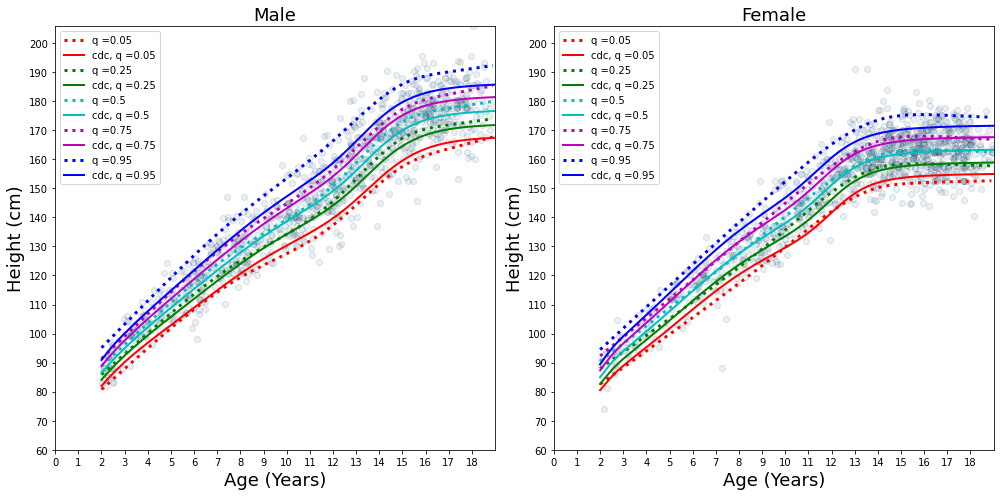

In [58]:
# Plot the results
if cdc_df is not None:
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    cdc_df = cdc_df[cdc_df['Age']>=2]
    
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response, ystart=60)

In [59]:
# Import cdc data
# 2 to 20years
infile  = '/home/jupyteruser/smipipeline/growth_curves/data/csv/bmiage220.csv'
df_cdc_wt= pd.read_csv(infile, index_col=False)
df_cdc_wt['Age'] = df_cdc_wt['Agemos']/12
df_cdc_wt = df_cdc_wt[['Sex','Age','P10','P25','P50','P75','P90']]

response='BMI_CALC'
cdc_df = df_cdc_wt
# Get optimal model config
df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Population comparison to cdc data on BMI_CALC using quantile regression
xstart:  0
ystart:  10
xstart:  0
ystart:  10


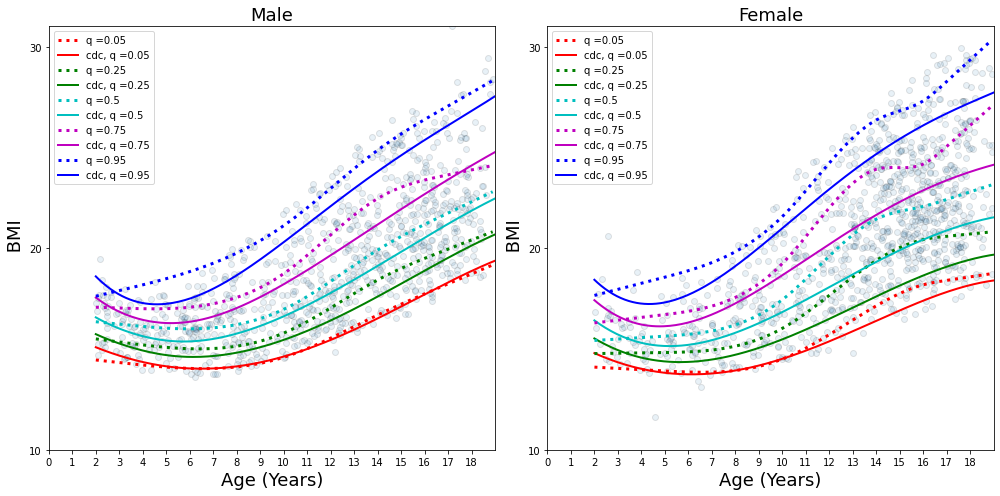

In [60]:
# Plot the results
if cdc_df is not None:
    cdc_df = cdc_df[cdc_df['Age']>=2]
    print('Population comparison to cdc data on ' + response + ' using quantile regression')
    plot_bs_qr_wcdc_cr([df_m_nonull,df_f_nonull],
               [fit_models_m,fit_models_f],
               knots=[knots_m,knots_f],
               cdc_df = cdc_df,
               response=response, ystart=10)

In [61]:
response='area_cm2'

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m, response)
model_f,knots_f = spline_model_optimizer_cr(df_f, response)


# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

In [62]:
knots_m

[3.0, 8.0, 12.0, 15.0, 17.0]

In [63]:
knots_f

[4.0, 10.0, 14.0, 15.0, 17.0]

Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)
Total outliers:  109 Total points:  1043
xstart:  0
ystart:  0
Total outliers:  117 Total points:  1125
xstart:  0
ystart:  0


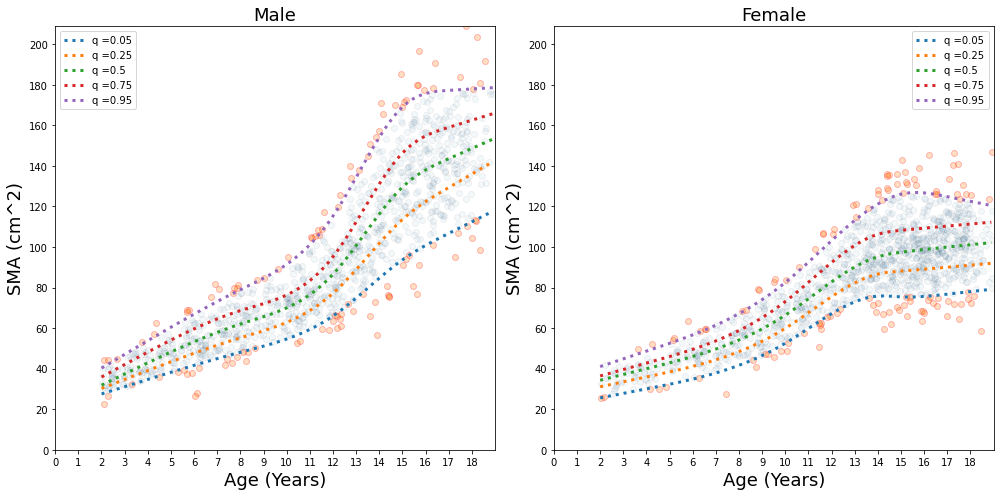

In [64]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Area (CCHMC data)')
results_df = plot_bs_qr_cr([df_m,df_f],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)
results_df.to_csv(os.path.join(output,'age_sma_table.csv'))

In [67]:
response='smi'

df_m_nonull = df_m.dropna(subset=[response])
df_f_nonull = df_f.dropna(subset=[response])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

In [68]:
knots_m

[3.0, 8.0, 12.0, 15.0, 17.0]

In [69]:
knots_f

[4.0, 10.0, 14.0, 15.0, 17.0]

Quantile Regression with Splines for SMI [CCHMC data]
Total outliers:  109 Total points:  1039
xstart:  0
ystart:  0
Total outliers:  117 Total points:  1118
xstart:  0
ystart:  0


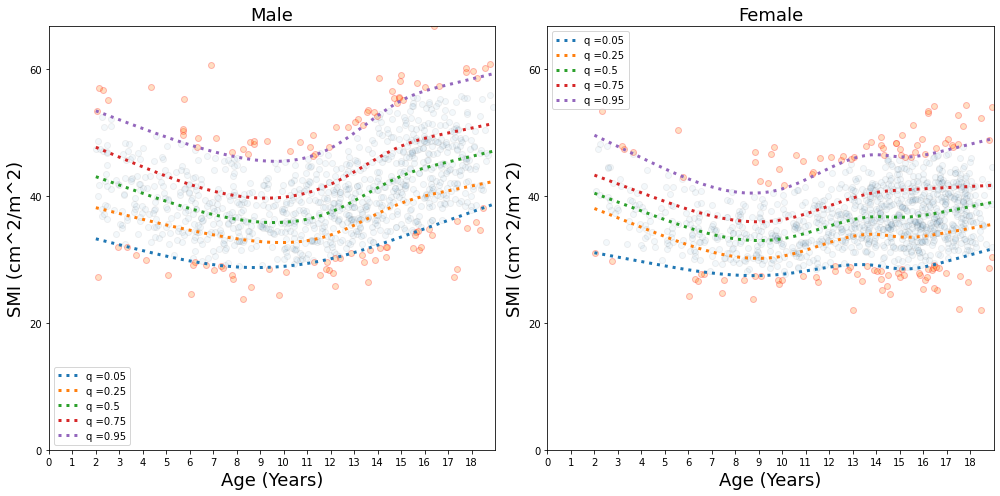

In [70]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data]')
results_df = plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response)
results_df.to_csv(os.path.join(output,'age_smi_table.csv'))

In [71]:
response='area_cm2'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for SMA [CCHMC data] vs Weight
Total outliers:  108 Total points:  1027
xstart:  10
ystart:  0
Total outliers:  114 Total points:  1113
xstart:  10
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,10.042774,9.961536,10.816391,11.659009,12.615076,14.553474,15.534232,15.983855,17.902767,21.320485
1,2.5,10.892068,10.941539,11.873902,12.792087,13.910901,15.179932,16.239889,16.759519,18.730182,22.228190
2,3.0,11.741362,11.921542,12.931413,13.925166,15.206726,15.806390,16.945546,17.535182,19.557597,23.135894
3,3.5,12.590656,12.901545,13.988924,15.058245,16.502550,16.432848,17.651203,18.310846,20.385011,24.043599
4,4.0,13.439950,13.881548,15.046435,16.191323,17.798375,17.059306,18.356860,19.086509,21.212426,24.951304
5,4.5,14.289244,14.861552,16.103946,17.324402,19.094200,17.685764,19.062518,19.862173,22.039841,25.859008
6,5.0,15.138538,15.841555,17.161457,18.457481,20.390025,18.312223,19.768175,20.637837,22.867255,26.766713
7,5.5,15.987832,16.821558,18.218968,19.590560,21.685850,18.938681,20.473832,21.413500,23.694670,27.674418
8,6.0,16.837126,17.801561,19.276479,20.723638,22.981675,19.565139,21.179489,22.189164,24.522085,28.582122
9,6.5,17.686420,18.781564,20.333990,21.856717,24.277500,20.191597,21.885146,22.964828,25.349499,29.489827


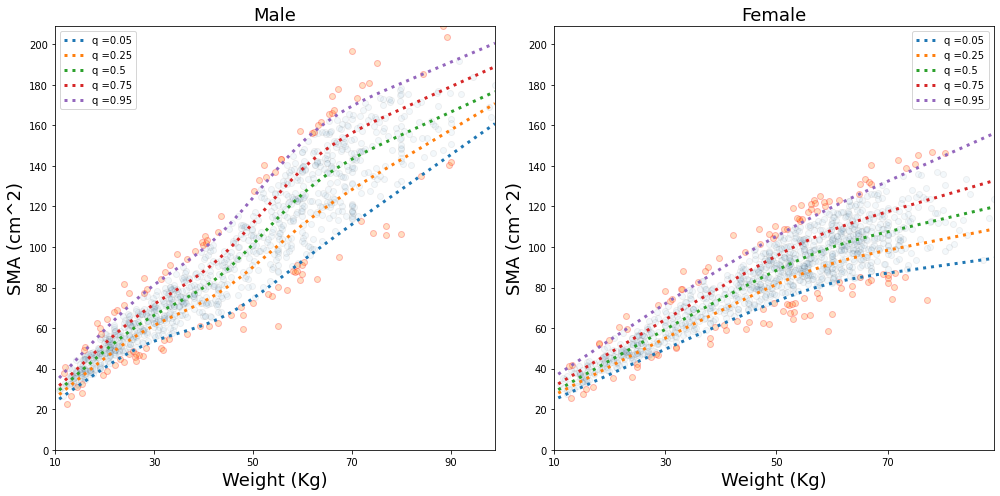

In [72]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor,xstart=10)

In [73]:
response='smi'
predictor='WEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMI [CCHMC data] vs Weight
Total outliers:  107 Total points:  1026
xstart:  10
ystart:  0
Total outliers:  114 Total points:  1111
xstart:  10
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,33.309162,39.754971,44.309211,52.924767,58.741037,26.818173,35.044958,38.985024,45.007367,51.748214
1,2.5,33.213718,39.621004,44.145540,52.648370,58.489523,26.846915,34.967069,38.882688,44.835386,51.564194
2,3.0,33.118274,39.487037,43.981868,52.371972,58.238010,26.875658,34.889181,38.780352,44.663405,51.380175
3,3.5,33.022829,39.353070,43.818197,52.095575,57.986496,26.904400,34.811292,38.678016,44.491424,51.196155
4,4.0,32.927385,39.219102,43.654525,51.819177,57.734983,26.933142,34.733404,38.575680,44.319443,51.012135
5,4.5,32.831941,39.085135,43.490854,51.542780,57.483470,26.961885,34.655516,38.473345,44.147462,50.828116
6,5.0,32.736497,38.951168,43.327182,51.266382,57.231956,26.990627,34.577627,38.371009,43.975482,50.644096
7,5.5,32.641053,38.817201,43.163510,50.989985,56.980443,27.019370,34.499739,38.268673,43.803501,50.460076
8,6.0,32.545609,38.683233,42.999839,50.713587,56.728929,27.048112,34.421850,38.166337,43.631520,50.276057
9,6.5,32.450164,38.549266,42.836167,50.437190,56.477416,27.076854,34.343962,38.064001,43.459539,50.092037


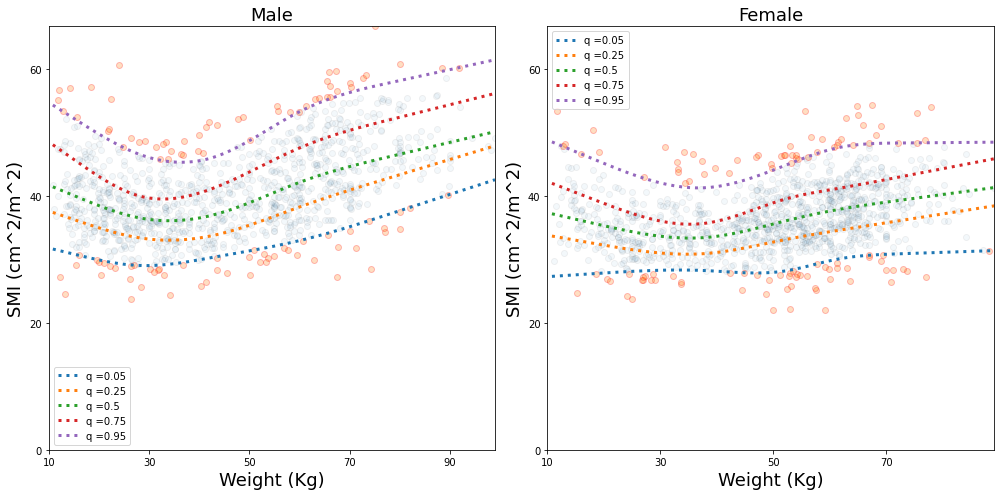

In [74]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs Weight')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart = 10)

In [75]:
response='area_cm2'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT
Total outliers:  107 Total points:  1039
xstart:  80
ystart:  0
Total outliers:  115 Total points:  1118
xstart:  80
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,-24.916504,-24.037702,-27.504527,-22.837129,-29.788675,-17.254341,-11.181937,-12.689095,-10.307594,-15.540182
1,2.5,-24.624623,-23.725309,-27.154616,-22.488730,-29.370145,-17.011442,-10.942670,-12.430414,-10.041149,-15.219801
2,3.0,-24.332742,-23.412916,-26.804706,-22.140331,-28.951615,-16.768543,-10.703404,-12.171734,-9.774704,-14.899421
3,3.5,-24.040862,-23.100524,-26.454795,-21.791932,-28.533084,-16.525644,-10.464137,-11.913054,-9.508259,-14.579040
4,4.0,-23.748981,-22.788131,-26.104884,-21.443533,-28.114554,-16.282745,-10.224871,-11.654374,-9.241814,-14.258660
5,4.5,-23.457100,-22.475738,-25.754974,-21.095134,-27.696024,-16.039845,-9.985604,-11.395693,-8.975370,-13.938279
6,5.0,-23.165220,-22.163345,-25.405063,-20.746734,-27.277493,-15.796946,-9.746338,-11.137013,-8.708925,-13.617898
7,5.5,-22.873339,-21.850953,-25.055153,-20.398335,-26.858963,-15.554047,-9.507072,-10.878333,-8.442480,-13.297518
8,6.0,-22.581458,-21.538560,-24.705242,-20.049936,-26.440433,-15.311148,-9.267805,-10.619652,-8.176035,-12.977137
9,6.5,-22.289577,-21.226167,-24.355331,-19.701537,-26.021902,-15.068249,-9.028539,-10.360972,-7.909590,-12.656757


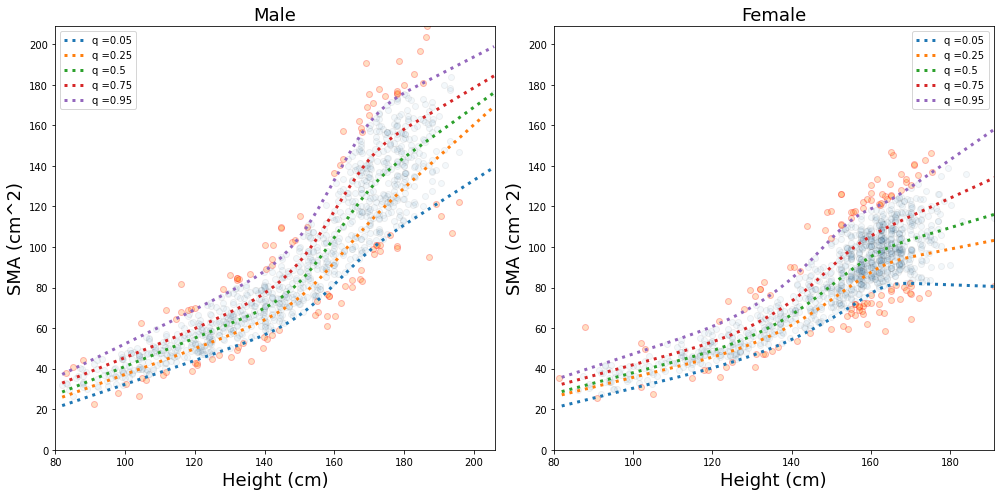

In [76]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response,predictor=predictor, xstart=80)

In [77]:
response='smi'
predictor='HEIGHT'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT
Total outliers:  109 Total points:  1039
xstart:  80
ystart:  0
Total outliers:  115 Total points:  1118
xstart:  80
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,42.940725,50.663288,54.790540,66.425237,70.725096,42.041881,55.269854,56.977223,66.210109,72.578524
1,2.5,42.886943,50.594688,54.719599,66.317995,70.629136,41.982146,55.169697,56.880263,66.085865,72.451537
2,3.0,42.833162,50.526088,54.648657,66.210752,70.533177,41.922410,55.069540,56.783303,65.961621,72.324551
3,3.5,42.779380,50.457488,54.577715,66.103510,70.437217,41.862675,54.969383,56.686343,65.837377,72.197565
4,4.0,42.725599,50.388889,54.506773,65.996267,70.341257,41.802940,54.869226,56.589384,65.713133,72.070578
5,4.5,42.671817,50.320289,54.435831,65.889024,70.245298,41.743204,54.769069,56.492424,65.588889,71.943592
6,5.0,42.618035,50.251689,54.364889,65.781782,70.149338,41.683469,54.668912,56.395464,65.464645,71.816606
7,5.5,42.564254,50.183089,54.293947,65.674539,70.053378,41.623733,54.568755,56.298504,65.340401,71.689619
8,6.0,42.510472,50.114490,54.223006,65.567296,69.957419,41.563998,54.468598,56.201545,65.216157,71.562633
9,6.5,42.456691,50.045890,54.152064,65.460054,69.861459,41.504263,54.368440,56.104585,65.091913,71.435647


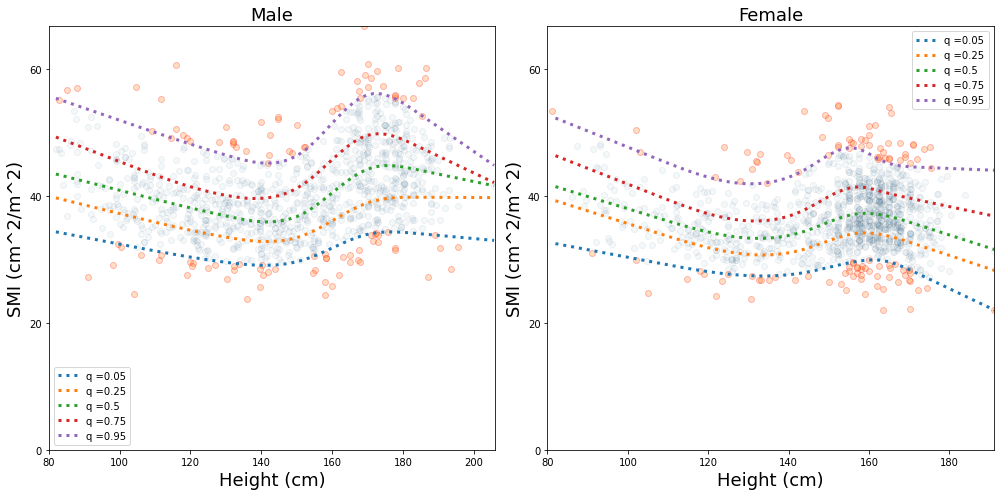

In [78]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs HEIGHT')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m,knots_f],
           response=response, predictor=predictor, xstart=80)

In [79]:
response='area_cm2'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull,response, predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull,response, predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile
Total outliers:  109 Total points:  1043
xstart:  0
ystart:  0
Total outliers:  117 Total points:  1125
xstart:  0
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,28.332613,50.965282,72.140472,100.291835,123.984340,32.562672,40.338048,69.066236,83.243667,96.340595
1,2.5,28.504658,51.196293,72.378467,100.698090,124.457727,32.727037,40.697911,69.240089,83.397686,96.543031
2,3.0,28.676703,51.427304,72.616462,101.104345,124.931114,32.891401,41.057775,69.413943,83.551705,96.745467
3,3.5,28.848748,51.658316,72.854458,101.510599,125.404501,33.055766,41.417639,69.587797,83.705724,96.947903
4,4.0,29.020793,51.889327,73.092453,101.916854,125.877888,33.220130,41.777503,69.761651,83.859742,97.150339
5,4.5,29.192839,52.120338,73.330448,102.323109,126.351275,33.384494,42.137367,69.935504,84.013761,97.352775
6,5.0,29.364884,52.351349,73.568444,102.729363,126.824662,33.548859,42.497231,70.109358,84.167780,97.555212
7,5.5,29.536929,52.582360,73.806439,103.135618,127.298049,33.713223,42.857094,70.283212,84.321799,97.757648
8,6.0,29.708974,52.813371,74.044434,103.541873,127.771436,33.877587,43.216958,70.457066,84.475817,97.960084
9,6.5,29.881019,53.044383,74.282429,103.948127,128.244823,34.041952,43.576822,70.630919,84.629836,98.162520


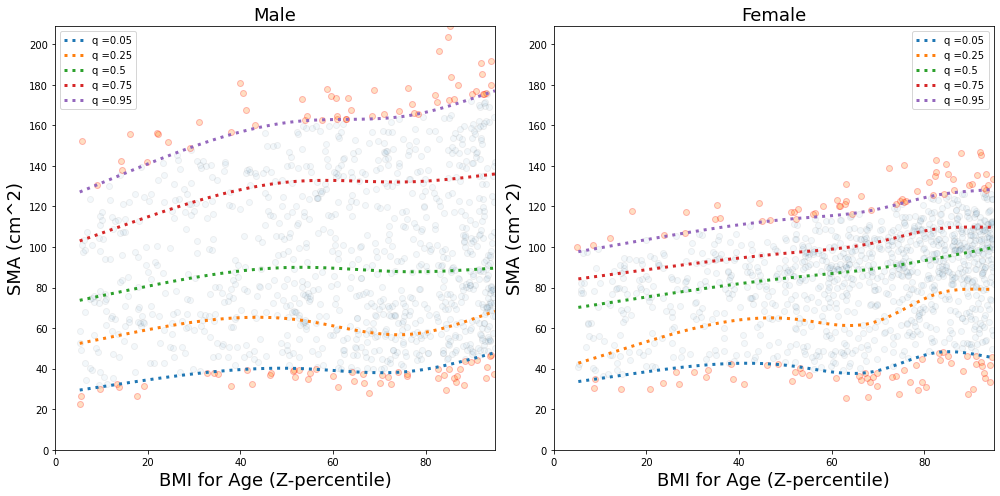

In [80]:
# Plot the results
print('Quantile Regression with Splines for SMA [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor)

In [81]:
response='smi'
predictor='bmi_age_Zpercentile'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

In [82]:
knots_f

[25.0, 69.0, 91.0]

Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile
Total outliers:  107 Total points:  1039
xstart:  0
ystart:  10
Total outliers:  115 Total points:  1118
xstart:  0
ystart:  10


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,26.813111,32.397668,34.648776,36.799767,40.059736,26.314392,29.148138,32.007223,33.968697,39.023084
1,2.5,26.878879,32.434421,34.709188,36.895747,40.212830,26.339085,29.176099,32.036190,34.007996,39.050351
2,3.0,26.944647,32.471173,34.769600,36.991726,40.365924,26.363779,29.204060,32.065156,34.047296,39.077618
3,3.5,27.010415,32.507926,34.830012,37.087705,40.519019,26.388472,29.232021,32.094123,34.086595,39.104885
4,4.0,27.076183,32.544679,34.890424,37.183684,40.672113,26.413166,29.259983,32.123089,34.125894,39.132152
5,4.5,27.141951,32.581432,34.950836,37.279663,40.825208,26.437859,29.287944,32.152056,34.165194,39.159419
6,5.0,27.207719,32.618184,35.011248,37.375642,40.978302,26.462553,29.315905,32.181022,34.204493,39.186686
7,5.5,27.273487,32.654937,35.071660,37.471621,41.131396,26.487246,29.343866,32.209989,34.243793,39.213953
8,6.0,27.339255,32.691690,35.132072,37.567600,41.284491,26.511940,29.371827,32.238955,34.283092,39.241220
9,6.5,27.405023,32.728443,35.192484,37.663579,41.437585,26.536633,29.399788,32.267922,34.322391,39.268487


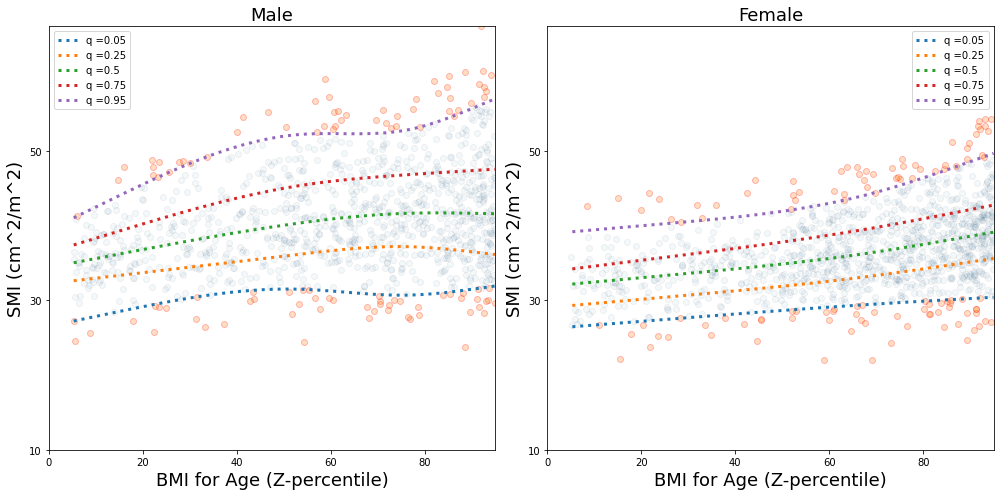

In [83]:
# Plot the results
print('Quantile Regression with Splines for SMI [CCHMC data] vs BMI percentile')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, ystart = 10)

In [84]:
response='area_cm2'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m, qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f, qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  95 Total points:  903
xstart:  12
ystart:  0
Total outliers:  108 Total points:  1016
xstart:  12
ystart:  0


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,30.963894,43.369474,35.316104,52.321336,9.746021,12.340658,-7.473802,-44.969846,-83.033023,-48.808509
1,2.5,31.008929,43.338088,35.904366,52.584880,12.215046,13.071121,-5.610114,-41.372499,-77.626185,-44.089332
2,3.0,31.053964,43.306702,36.492627,52.848425,14.684071,13.801585,-3.746425,-37.775151,-72.219347,-39.370154
3,3.5,31.098998,43.275316,37.080889,53.111970,17.153096,14.532049,-1.882737,-34.177803,-66.812509,-34.650977
4,4.0,31.144033,43.243930,37.669150,53.375514,19.622121,15.262512,-0.019049,-30.580455,-61.405671,-29.931799
5,4.5,31.189068,43.212545,38.257412,53.639059,22.091146,15.992976,1.844639,-26.983108,-55.998832,-25.212622
6,5.0,31.234102,43.181159,38.845673,53.902604,24.560171,16.723440,3.708327,-23.385760,-50.591994,-20.493445
7,5.5,31.279137,43.149773,39.433935,54.166148,27.029196,17.453903,5.572015,-19.788412,-45.185156,-15.774267
8,6.0,31.324172,43.118387,40.022196,54.429693,29.498221,18.184367,7.435703,-16.191064,-39.778318,-11.055090
9,6.5,31.369206,43.087001,40.610458,54.693238,31.967246,18.914830,9.299392,-12.593717,-34.371480,-6.335912


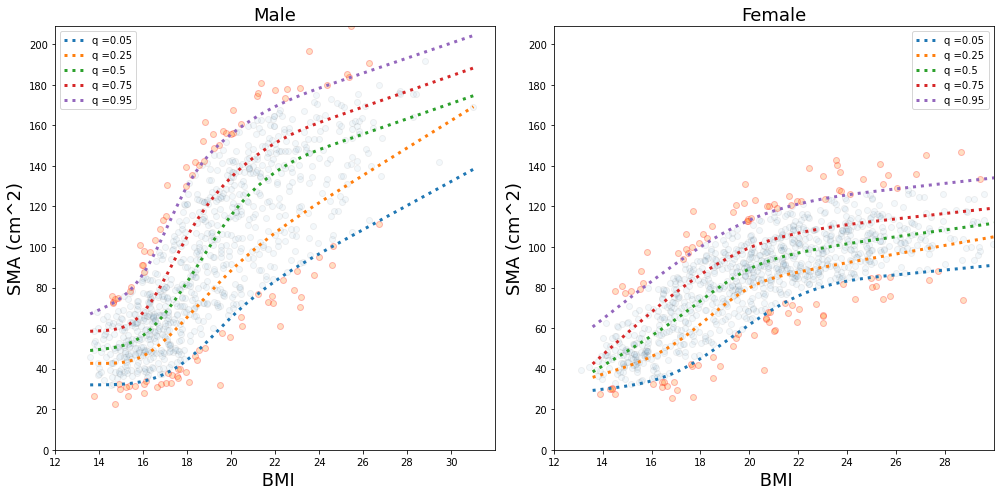

In [85]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull, df_f_nonull],
           [fit_models_m,fit_models_f],
           knots=[knots_m, knots_f],
           response=response, predictor=predictor, xstart=12)

In [86]:
response='smi'
predictor='BMI_CALC'

df_m_nonull = df_m.dropna(subset=[response,predictor])
df_f_nonull = df_f.dropna(subset=[response,predictor])

# Get optimal model config
model_m,knots_m = spline_model_optimizer_cr(df_m_nonull, response,predictor_var=predictor)
model_f,knots_f = spline_model_optimizer_cr(df_f_nonull, response,predictor_var=predictor)

# Fit the model for different quantiles
fit_models_m = fit_bs_models(model_m,qlist=[0.05,0.25,0.50,0.75,0.95])
fit_models_f = fit_bs_models(model_f,qlist=[0.05,0.25,0.50,0.75,0.95])

/home/jupyteruser/.local/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:190: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI
Total outliers:  96 Total points:  900
xstart:  12
ystart:  10
Total outliers:  105 Total points:  1010
xstart:  12
ystart:  10


,Age,0.05,0.25,0.50,0.75,0.95,0.05,0.25,0.50,0.75,0.95
0,2.0,-9.623081,14.398167,6.972116,-5.632215,-27.444898,12.337391,18.579115,23.941524,25.338182,42.786171
1,2.5,-8.172717,15.124492,8.096974,-3.917808,-24.688075,12.883939,19.035214,24.311542,25.751094,42.758693
2,3.0,-6.722353,15.850817,9.221832,-2.203401,-21.931253,13.430487,19.491313,24.681561,26.164006,42.731215
3,3.5,-5.271989,16.577142,10.346690,-0.488995,-19.174431,13.977036,19.947412,25.051579,26.576918,42.703738
4,4.0,-3.821624,17.303468,11.471549,1.225412,-16.417609,14.523584,20.403512,25.421598,26.989830,42.676260
5,4.5,-2.371260,18.029793,12.596407,2.939819,-13.660787,15.070132,20.859611,25.791616,27.402742,42.648782
6,5.0,-0.920896,18.756118,13.721265,4.654226,-10.903964,15.616681,21.315710,26.161635,27.815654,42.621304
7,5.5,0.529468,19.482443,14.846123,6.368633,-8.147142,16.163229,21.771809,26.531653,28.228566,42.593826
8,6.0,1.979833,20.208768,15.970981,8.083040,-5.390320,16.709777,22.227909,26.901672,28.641478,42.566349
9,6.5,3.430197,20.935094,17.095839,9.797447,-2.633498,17.256326,22.684008,27.271691,29.054390,42.538871


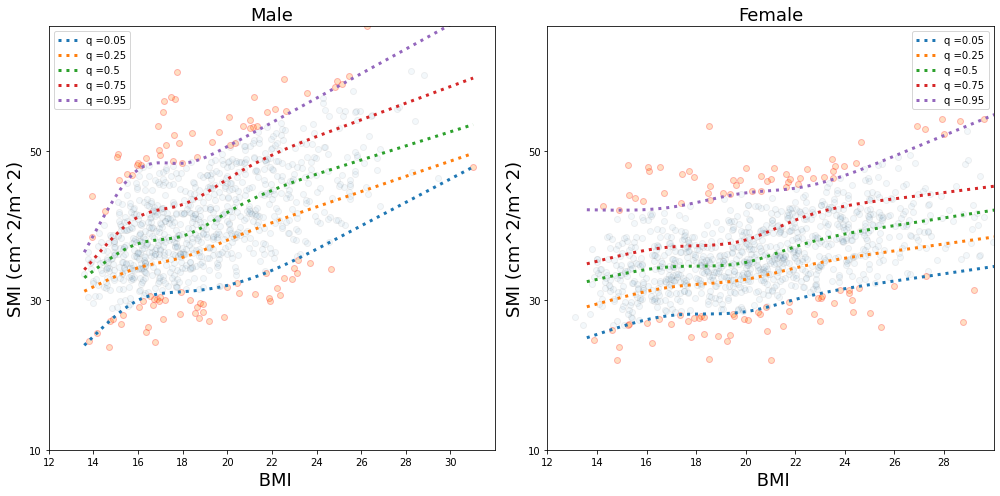

In [87]:
# Plot the results
print('Quantile Regression with Splines for Skeletal Muscle Index [CCHMC data] vs BMI')
plot_bs_qr_cr([df_m_nonull,df_f_nonull],
           [fit_models_m, fit_models_f],
           knots=[knots_m, knots_f],
           response=response,predictor=predictor, xstart=12, ystart=10)